In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import time
import gc
from tqdm import trange

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

# Load Data and Preprocessing

## UNSW-NB15

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW_NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW_NB15/test.csv')
print(test_raw.shape)
# Seperate label and drop unnecessary features
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['label']

(82332, 45)
(175341, 45)
(82332, 39)
(175341, 39)


## NSL-KDD

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/NSL_KDD/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/NSL_KDD/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal':
        return 0
    else:
        return 1
train_X = train_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['class'].apply(LabelEncode)
print(train_Y.unique())
test_X = test_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['class'].apply(LabelEncode)

(125973, 42)
(22544, 42)
(125973, 38)
[0 1]
(22544, 38)


## CICIDS-2017

In [9]:
# Load Data
train_raw = pd.read_csv('../Data/CICIDS_2017/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/CICIDS_2017/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'BENIGN':
        return 0
    else:
        return 1
train_X = train_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw[' Label'].apply(LabelEncode)
test_X = test_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw[' Label'].apply(LabelEncode)

(500000, 81)
(500000, 81)
(500000, 78)
(500000, 78)


# Feature Selection

In [10]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

In [11]:
# correlation based feature selection
corr = train_X1.corr().abs()

correlation_threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > correlation_threshold:
            redundant.append((i, j))

train_corr = train_X1.copy()
train_corr['Label'] = train_Y
corr2 = train_corr.corr().abs()

corr3 = corr2['Label'].iloc[:-1].copy()
drop = []

# drop features having lower correlation with label
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

del corr, train_corr, corr2, corr3
gc.collect()

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)
test_X1 = test_X1.drop(drop, axis=1)
print(test_X1.shape)

[' Total Backward Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Flow IAT Std', ' Flow Duration', ' Fwd IAT Mean', ' Flow IAT Max', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Max', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'Fwd PSH Flags', ' Fwd URG Flags', ' RST Flag Count', ' Average Packet Size', ' Fwd Packet Length Mean', ' Avg Bwd Segment Size', ' Fwd Header Length', ' Total Fwd Packets', 'Total Length of Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Fwd Header Length.1', 'Active Mean', 'Idle Mean', ' Idle Max', ' Idle Min']
(500000, 42)
(500000, 42)


In [12]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
dataset_name = 'CICIDS_2017'
methods = ['chi2', 'ANOVA', 'mutualinfo', 'sfs(gb)', 'sfs(lr)', 'im(gb)', 'im(lr)']
colors = ['blue', 'red', 'black', 'cyan', 'darkcyan', 'green', 'darkgreen']
subset_all = []
n_of_features = train_X1.shape[1]
kf = StratifiedKFold(shuffle=True, random_state=0)

In [14]:
# select 1 best feature iteratively with chi2, ANOVA, mutual info

for sf in [chi2, f_classif, mutual_info_classif]:
    selector = SelectKBest(sf, k='all')
    selector.fit(train_X1, train_Y)
    sorted_index = np.argsort(-selector.scores_)
    subset_all.append(train_X1.columns[sorted_index])
    print(train_X1.columns[sorted_index])

Index([' PSH Flag Count', ' Bwd Packet Length Std', ' Fwd IAT Std',
       ' URG Flag Count', 'FIN Flag Count', 'Fwd IAT Total',
       ' Destination Port', ' SYN Flag Count', ' Init_Win_bytes_backward',
       ' Bwd Packet Length Min', ' Bwd IAT Std', ' Idle Std',
       ' Min Packet Length', ' Flow IAT Mean', ' Fwd Packet Length Min',
       ' Avg Fwd Segment Size', 'Init_Win_bytes_forward', ' ACK Flag Count',
       ' Bwd IAT Min', ' Bwd Packets/s', 'Fwd Packets/s', ' ECE Flag Count',
       ' Active Std', ' Active Max', ' CWE Flag Count', ' Subflow Fwd Bytes',
       ' Active Min', ' Flow IAT Min', 'Subflow Fwd Packets', ' Down/Up Ratio',
       ' min_seg_size_forward', ' Bwd Header Length', 'Bwd Avg Bulk Rate',
       ' Fwd Avg Bulk Rate', ' Fwd Avg Packets/Bulk', 'Flow Bytes/s',
       ' Flow Packets/s', 'Fwd Avg Bytes/Bulk', ' Bwd PSH Flags',
       ' Bwd URG Flags', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk'],
      dtype='object')
Index([' Bwd Packet Length Std', ' Fwd IAT

In [15]:
# select 1 best feature iteratively with SFS, using RF, LR
for model in [GradientBoostingClassifier(random_state=0), RidgeClassifier(random_state=0)]:
    cols = []
    selector = SequentialFeatureSelector(model, n_features_to_select=1, scoring='f1', cv=kf, n_jobs=-1)
    for k in trange(n_of_features-1):
        train_X2 = train_X1.drop(cols, axis=1)
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 41/41 [2:25:10<00:00, 212.44s/it]  


[' Init_Win_bytes_backward', ' Destination Port', 'Init_Win_bytes_forward', ' Subflow Fwd Bytes', ' Bwd Packet Length Min', ' Bwd Packet Length Std', ' Avg Fwd Segment Size', ' Bwd Packets/s', ' Fwd IAT Std', 'Fwd IAT Total', 'Fwd Packets/s', ' Flow IAT Mean', ' Bwd IAT Std', ' Fwd Packet Length Min', ' Min Packet Length', 'Subflow Fwd Packets', ' Active Max', ' Active Min', 'FIN Flag Count', ' Down/Up Ratio', ' Idle Std', ' Flow IAT Min', ' Bwd IAT Min', ' Active Std', 'Flow Bytes/s', ' Flow Packets/s', ' Bwd PSH Flags', ' Bwd URG Flags', ' Bwd Header Length', ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', ' min_seg_size_forward']


100%|██████████| 41/41 [05:11<00:00,  7.60s/it]

[' Bwd Packet Length Std', ' Fwd IAT Std', 'FIN Flag Count', ' Bwd IAT Std', ' Idle Std', ' Flow IAT Mean', ' Bwd Packets/s', ' Destination Port', ' Fwd Packet Length Min', ' Bwd Packet Length Min', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Min', 'Fwd IAT Total', ' Bwd IAT Min', ' Bwd PSH Flags', ' Bwd URG Flags', ' Bwd Header Length', 'Fwd Packets/s', ' Min Packet Length', ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', ' Down/Up Ratio', ' Avg Fwd Segment Size', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 'Init_Win_bytes_forward', ' Init_Win_bytes_backward', ' min_seg_size_forward', ' Active Std', ' Active Max', ' Active Min']


In [16]:
# select 1 best feature iteratively with importance, using RF, LR
for model in [GradientBoostingClassifier(random_state=0), RidgeClassifier(random_state=0)]:
    cols = []
    selector = SelectFromModel(model, threshold=-np.inf, max_features=1)
    for k in trange(n_of_features-1):
        train_X2 = train_X1.drop(cols, axis=1)
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[selector.get_support()]
        cols.append(f[0])
    cols.append(train_X1.columns.drop(cols)[0])
    subset_all.append(cols)
    print(cols)

100%|██████████| 41/41 [28:15<00:00, 41.36s/it]  


[' Subflow Fwd Bytes', ' Avg Fwd Segment Size', ' Bwd Packet Length Std', ' Init_Win_bytes_backward', ' Destination Port', ' Min Packet Length', ' Fwd Packet Length Min', 'Init_Win_bytes_forward', ' Bwd Packet Length Min', ' PSH Flag Count', ' ACK Flag Count', ' Bwd Packets/s', 'Fwd Packets/s', 'Subflow Fwd Packets', ' Fwd IAT Std', ' Flow IAT Mean', 'Fwd IAT Total', ' Bwd IAT Std', ' Flow IAT Min', ' Active Min', ' Active Max', ' Down/Up Ratio', ' URG Flag Count', ' Active Std', ' Idle Std', 'FIN Flag Count', ' Bwd IAT Min', ' SYN Flag Count', ' Bwd Header Length', ' ECE Flag Count', ' CWE Flag Count', ' min_seg_size_forward', 'Flow Bytes/s', ' Flow Packets/s', ' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


100%|██████████| 41/41 [00:09<00:00,  4.23it/s]

[' Down/Up Ratio', ' Active Min', ' Fwd IAT Std', ' Flow IAT Mean', ' Bwd Packets/s', ' Active Std', ' Active Max', ' Avg Fwd Segment Size', ' Subflow Fwd Bytes', ' Bwd Packet Length Std', ' Min Packet Length', 'Subflow Fwd Packets', ' CWE Flag Count', ' PSH Flag Count', ' Bwd Packet Length Min', ' Fwd Packet Length Min', ' Idle Std', ' SYN Flag Count', ' Bwd IAT Min', 'FIN Flag Count', ' Bwd IAT Std', ' ECE Flag Count', ' Init_Win_bytes_backward', ' URG Flag Count', ' Flow IAT Min', ' Destination Port', 'Fwd IAT Total', ' min_seg_size_forward', 'Init_Win_bytes_forward', ' Bwd Header Length', 'Fwd Packets/s', ' ACK Flag Count', 'Flow Bytes/s', ' Flow Packets/s', ' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


In [17]:
# save selected feature sets to csv file
pd.DataFrame(subset_all, index=methods).to_csv('../Results/' + dataset_name + '/Individual_features.csv')

# Cross Validation and Test

## Linear Regression

In [18]:
# measure performance by cv(f1 score) and test(f1 score)
cv_time_all_LR = []
cv_f1_all_LR = []
test_time_all_LR = []
test_f1_all_LR = []
model = RidgeClassifier(alpha=0.01, random_state=0)
for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', cv=kf, n_jobs=-1)
        second2 = time.time()
        cv_time.append(second2 - second)
        cv_f1.append((cv.mean(), cv.std()))

        model.fit(train_X1[subset_all[i][:k+1]], train_Y)
        second = time.time()
        predict = model.predict(test_X1[subset_all[i][:k+1]])
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2 - second)
        test_f1.append(score)
    
    cv_time_all_LR.append(cv_time)
    cv_f1_all_LR.append(cv_f1)
    test_time_all_LR.append(test_time)
    test_f1_all_LR.append(test_f1)

100%|██████████| 42/42 [00:53<00:00,  1.28s/it]


In [19]:
pd.DataFrame(cv_time_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_LR.csv')
pd.DataFrame(cv_f1_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_LR.csv')
pd.DataFrame(test_time_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_LR.csv')
pd.DataFrame(test_f1_all_LR, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_LR.csv')

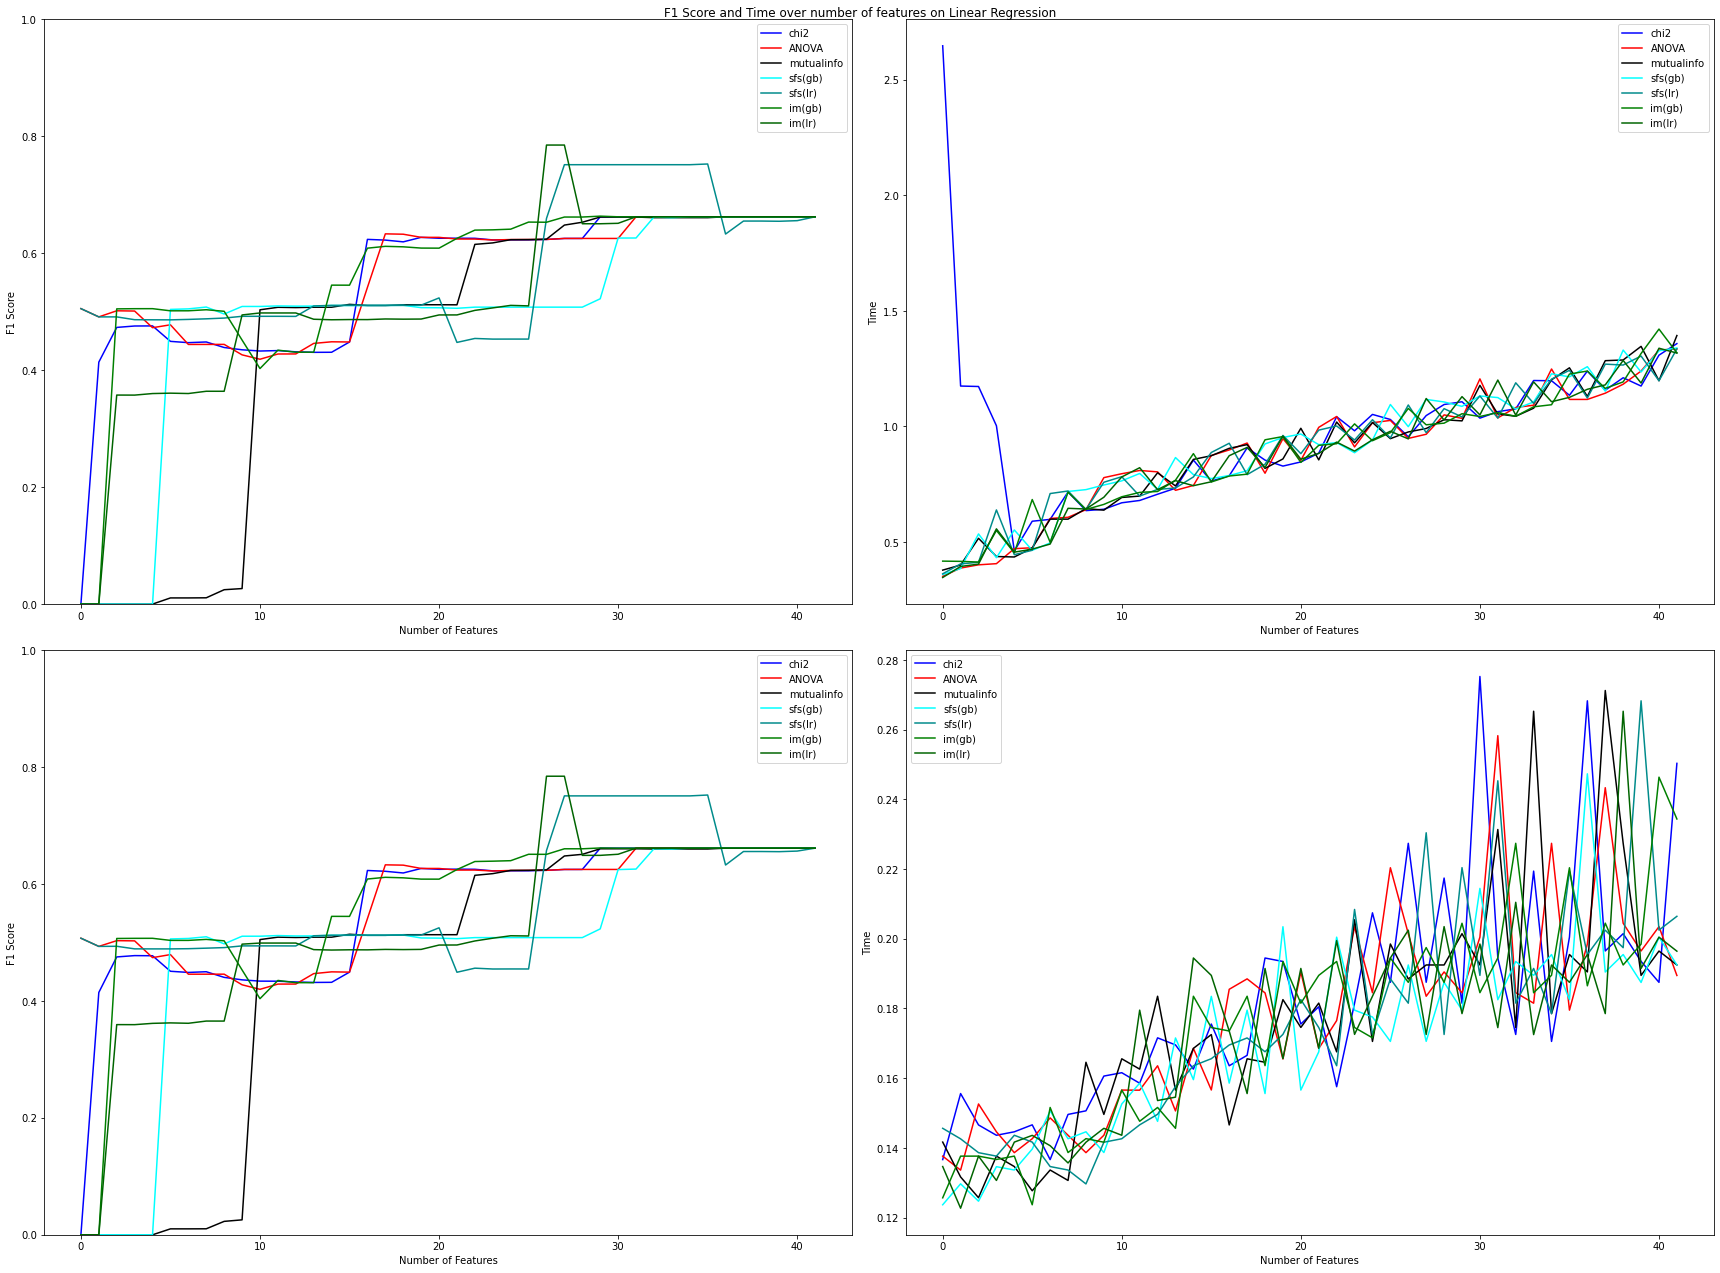

In [20]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Linear Regression')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_LR)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_LR)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_LR[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()

## Gradient Boosting Decision Tree

In [21]:
# measure performance by cv(f1 score) and test(f1 score)
cv_time_all_GB = []
cv_f1_all_GB = []
test_time_all_GB = []
test_f1_all_GB = []
model = GradientBoostingClassifier(n_estimators=200, random_state=0)
for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[subset_all[i][:k+1]], train_Y, scoring='f1', cv=kf, n_jobs=-1)
        second2 = time.time()
        cv_time.append(second2 - second)
        cv_f1.append((cv.mean(), cv.std()))

        model.fit(train_X1[subset_all[i][:k+1]], train_Y)
        second = time.time()
        predict = model.predict(test_X1[subset_all[i][:k+1]])
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2 - second)
        test_f1.append(score)
    
    cv_time_all_GB.append(cv_time)
    cv_f1_all_GB.append(cv_f1)
    test_time_all_GB.append(test_time)
    test_f1_all_GB.append(test_f1)

100%|██████████| 42/42 [3:52:22<00:00, 331.97s/it]  


In [22]:
pd.DataFrame(cv_time_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_GB.csv')
pd.DataFrame(cv_f1_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_GB.csv')
pd.DataFrame(test_time_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_GB.csv')
pd.DataFrame(test_f1_all_GB, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_GB.csv')

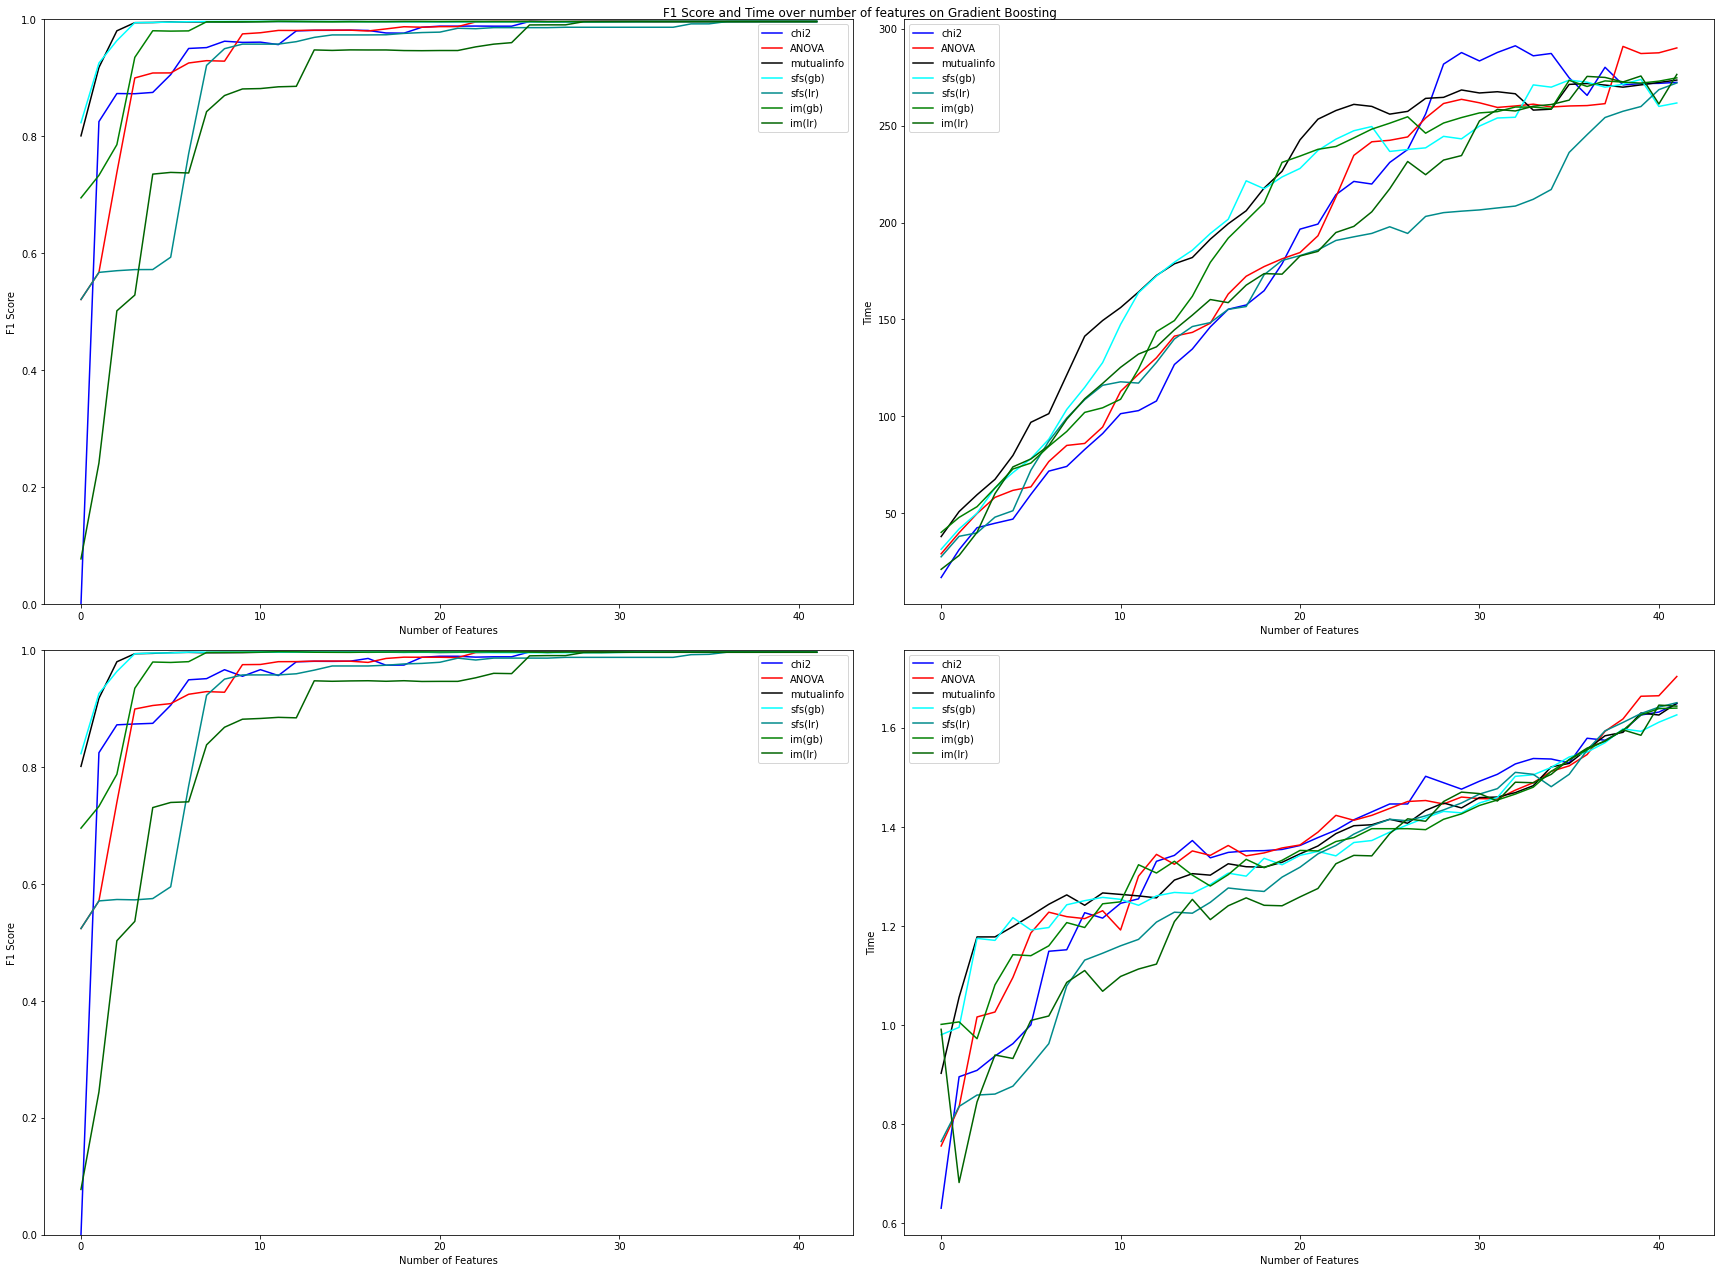

In [23]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Gradient Boosting')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_GB)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_GB)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_GB[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()

## Neuron Network

In [24]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, losses, metrics, callbacks

In [25]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
n_epoch = 15
batch_size = 100

In [27]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [28]:
cv_time_all_NN = []
cv_f1_all_NN = []
test_time_all_NN = []
test_f1_all_NN = []

for i in range(len(subset_all)):
    cv_time = []
    cv_f1 = []
    test_time = []
    test_f1 = []
    for k in trange(n_of_features):
        model = ModelCreate((k+1,))
        # cross validation
        j = 0
        cv_time_ = 0
        cv = np.zeros(shape=5)
        train_X2 = train_X1[subset_all[i][:k+1]].copy()
        for train_index, validation_index in kf.split(train_X2, train_Y):
            x_train_fold, x_validation_fold = train_X2.iloc[train_index, :], train_X2.iloc[validation_index, :]
            y_train_fold, y_validation_fold = train_Y.iloc[train_index], train_Y.iloc[validation_index]

            second = time.time()
            model.fit(x_train_fold.values, y_train_fold.values,
                epochs=n_epoch, batch_size=batch_size,
                use_multiprocessing=True, verbose=0)
            predict = model.predict(x_validation_fold, use_multiprocessing=True)
            predict = np.where(predict < 0.5, 0, 1)
            cv[j] = f1_score(y_validation_fold, predict)
            second2 = time.time()
            cv_time_ += second2 - second
            j += 1
        cv_time.append(cv_time_)
        cv_f1.append((cv.mean(), cv.std()))

        second = time.time()
        model.fit(train_X1[subset_all[i][:k+1]].values, train_Y.values,
                epochs=n_epoch, batch_size=batch_size,
                use_multiprocessing=True, verbose=0)
        predict = model.predict(test_X1[subset_all[i][:k+1]], use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        score = f1_score(test_Y, predict)
        second2 = time.time()
        test_time.append(second2-second)
        test_f1.append(score)
    
    cv_time_all_NN.append(cv_time)
    cv_f1_all_NN.append(cv_f1)
    test_time_all_NN.append(test_time)
    test_f1_all_NN.append(test_f1)

100%|██████████| 42/42 [15:39:50<00:00, 1342.63s/it]  


In [29]:
pd.DataFrame(cv_time_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_Time_NN.csv')
pd.DataFrame(cv_f1_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_CV_F1_NN.csv')
pd.DataFrame(test_time_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_Time_NN.csv')
pd.DataFrame(test_f1_all_NN, index=methods).to_csv('../Results/' + dataset_name + '/Individual_Test_F1_NN.csv')

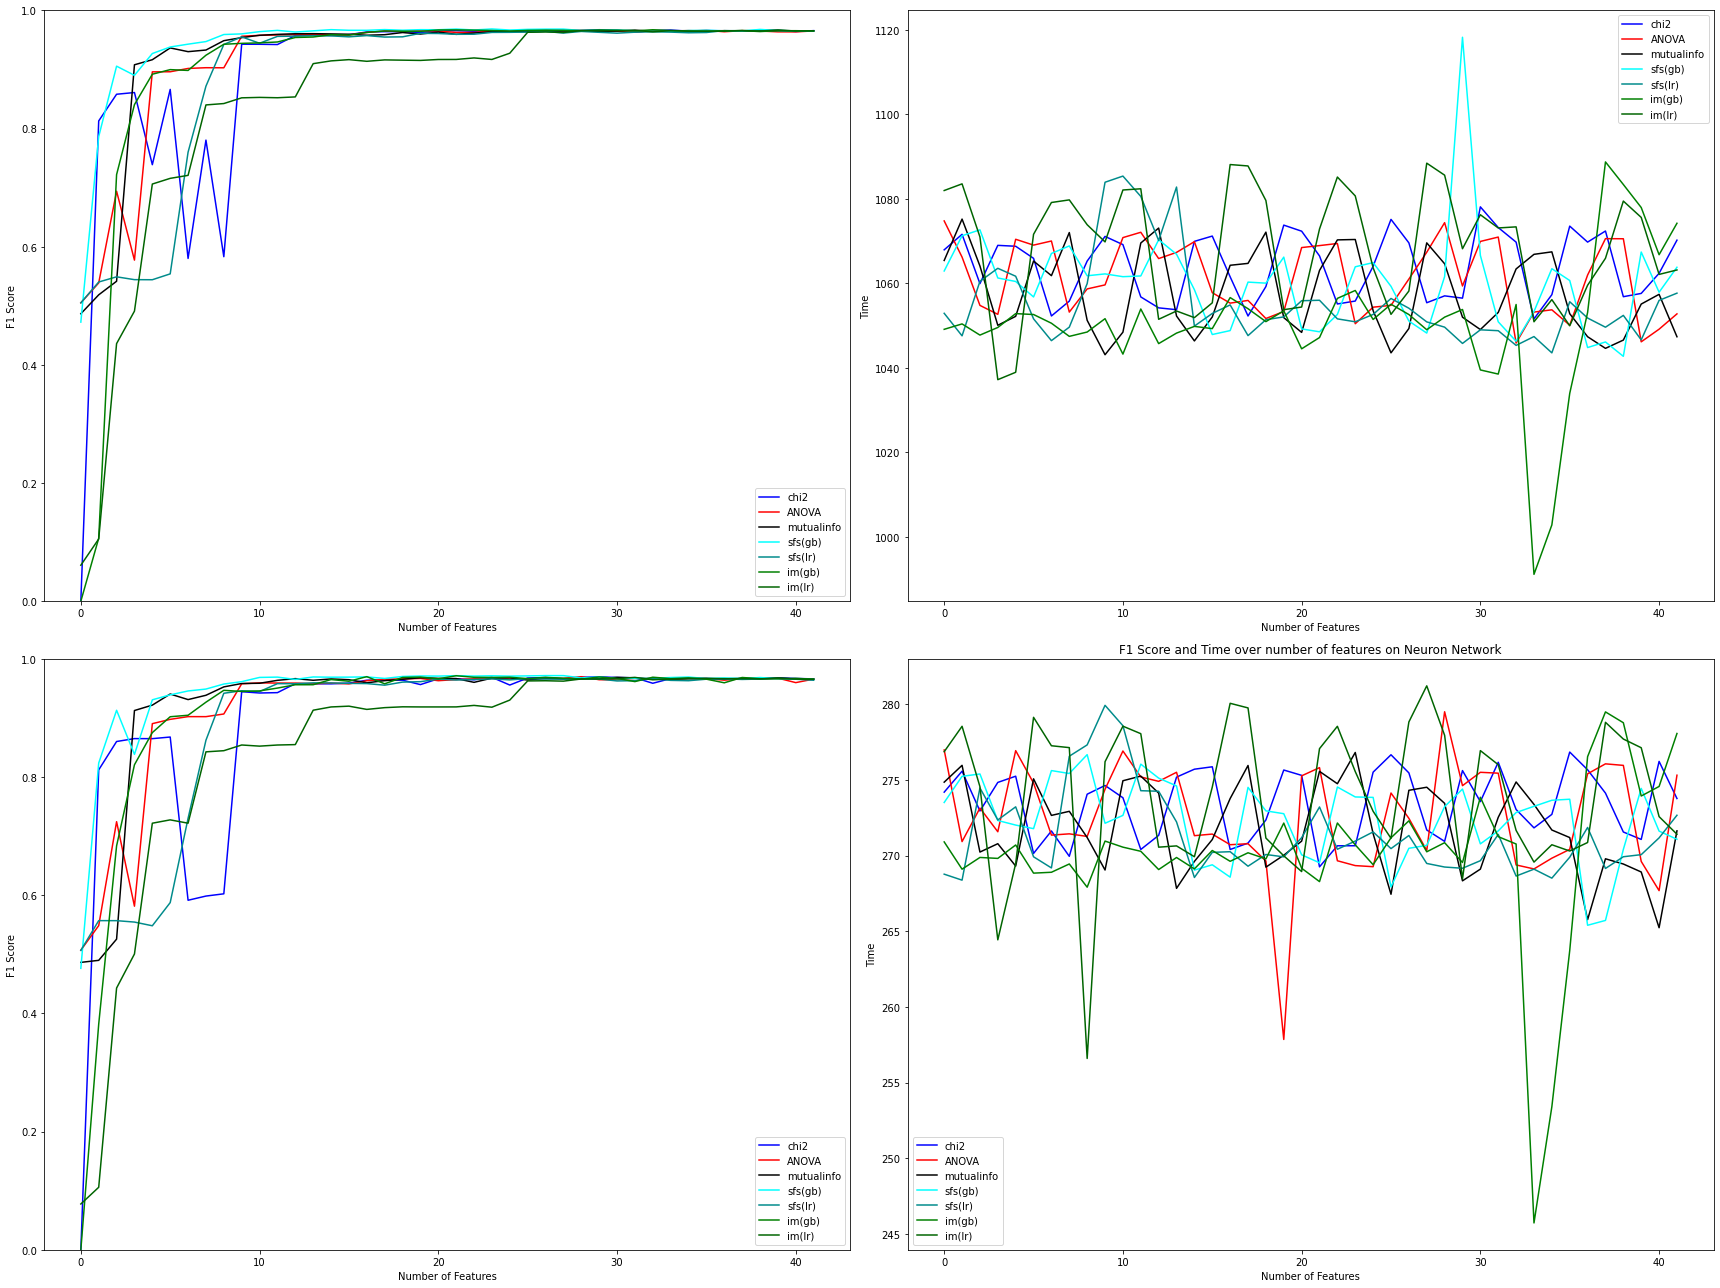

In [30]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.title('F1 Score and Time over number of features on Neuron Network', loc='center')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(cv_f1_all_NN)[i,:,0], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), cv_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

for i in range(len(methods)):
    plt.plot(range(n_of_features), np.array(test_f1_all_NN)[i,:], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

for i in range(len(methods)):
    plt.plot(range(n_of_features), test_time_all_NN[i], color=colors[i], linestyle='-', label=methods[i])

plt.legend()

plt.tight_layout()
plt.show()